In [140]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score

results_df = pd.read_csv(r'C:\Users\fabio\OneDrive\Desktop\WCA export\WCA_export134_20250514T000140Z.tsv\WCA_export_Results.tsv', sep='\t')
comps_df = pd.read_csv(r'C:\Users\fabio\OneDrive\Desktop\WCA export\WCA_export134_20250514T000140Z.tsv\WCA_export_Competitions.tsv', sep='\t')

comps_subset = comps_df[['id', 'year', 'endMonth', 'endDay']]

merged_df = pd.merge(
    results_df,
    comps_subset,
    left_on = 'competitionId',
    right_on = 'id'
)

merged_df.drop(columns=['id'], inplace=True)

In [141]:
results_df.columns

comps_df.columns

Index(['id', 'name', 'information', 'external_website', 'venue', 'latitude',
       'longitude', 'cityName', 'countryId', 'venueAddress', 'venueDetails',
       'cellName', 'cancelled', 'eventSpecs', 'wcaDelegate', 'organiser',
       'year', 'month', 'day', 'endMonth', 'endDay'],
      dtype='object')

In [189]:
merged_df.columns

merged_df['solve_date'] = pd.to_datetime({
    'year': merged_df['year'],
    'month': merged_df['endMonth'],
    'day': merged_df['endDay']
})

filtered = merged_df[(merged_df['personId'] == '2014SCHW02') & (merged_df['eventId'] == '333')]

df = filtered.sort_values('solve_date').reset_index(drop=True)

df['days_since_first'] = (df['solve_date'] - df['solve_date'].min()).dt.days



values_cols = ['value1', 'value2', 'value3', 'value4', 'value5']

# Melt value columns into one column 'solve_time'
df_melted = pd.melt(df,
                    id_vars=['personId', 'eventId', 'solve_date', 'year', 'endMonth', 'endDay',  'days_since_first'],
                    value_vars=values_cols,
                    var_name='attempt',
                    value_name='solve_time')

# Remove DNFs
df_clean = df_melted[(df_melted['solve_time'] > 0)]

df_clean = df_clean.sort_values('solve_date').reset_index(drop=True)

df_clean['solve_number'] = df_clean.index

# df_unclean = df_clean[(df_clean['solve_time'] < 0)]

# print(df_unclean.head)

X = df_clean[['days_since_first']]
y = df_clean['solve_time']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, shuffle=False)

# model = LinearRegression()
# model.fit(X_train, y_train)

# # Predict
# y_pred = model.predict(X_test)

from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(n_estimators=1000, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print("MAE:", mean_absolute_error(y_test, y_pred))
print("R² Score:", r2_score(y_test, y_pred))



MAE: 68.6601692963603
R² Score: -0.051115409648786025


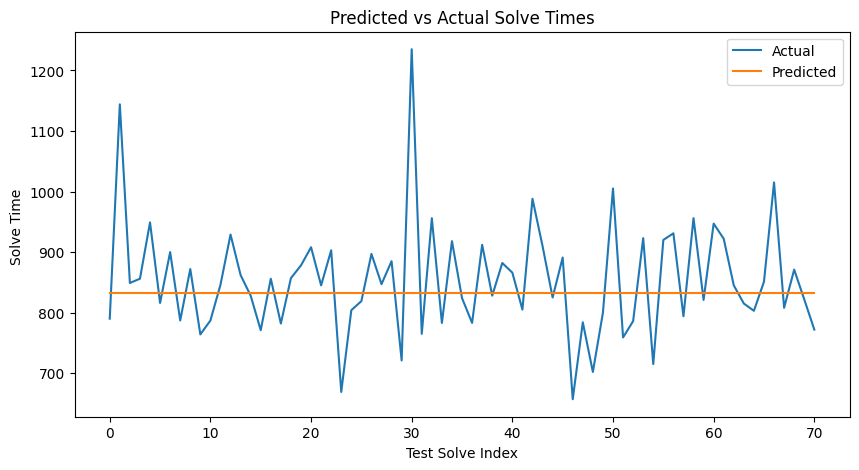

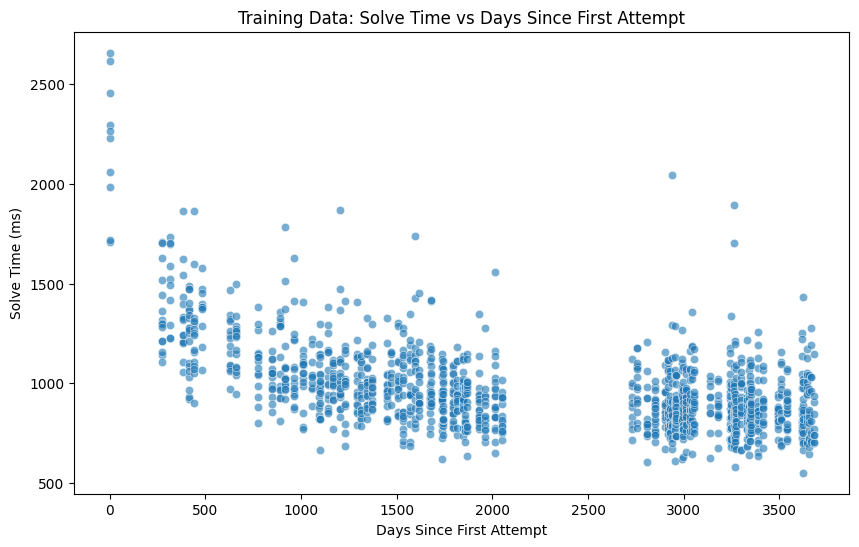

In [190]:
import matplotlib.pyplot as plt

import seaborn as sns

plt.figure(figsize=(10,5))
plt.plot(y_test.values, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.title("Predicted vs Actual Solve Times")
plt.xlabel("Test Solve Index")
plt.ylabel("Solve Time ")
plt.show()



plt.figure(figsize=(10,6))

sns.scatterplot(x=X_train['days_since_first'], y=y_train, alpha=0.6)

plt.title('Training Data: Solve Time vs Days Since First Attempt')
plt.xlabel('Days Since First Attempt')
plt.ylabel('Solve Time (ms)')
plt.show()

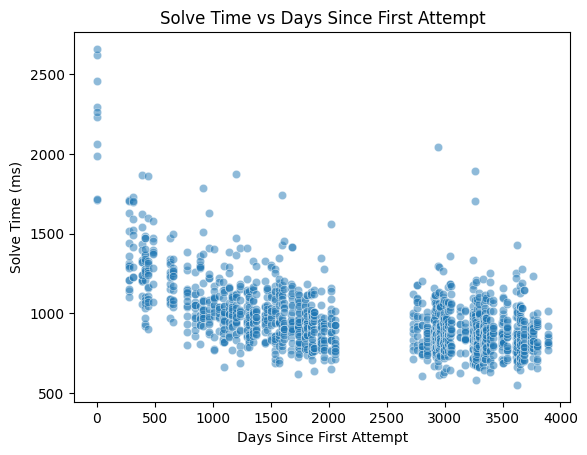

In [191]:
sns.scatterplot(data=df_clean, x='days_since_first', y='solve_time', alpha=0.5)

plt.title('Solve Time vs Days Since First Attempt')
plt.xlabel('Days Since First Attempt')
plt.ylabel('Solve Time (ms)')
plt.show()

In [192]:

last_day = df_clean['days_since_first'].max()



next_5_data = pd.DataFrame({
    'days_since_first': [last_day + i for i in range(1, 6)]
})


predicted_times = model.predict(next_5_data)

sorted_preds = np.sort(predicted_times)
middle_three = sorted_preds[1:4]
truncated_avg = np.mean(middle_three)

print(f"Predicted next round average: {(truncated_avg / 100):.2f}")

Predicted next round average: 8.33
